# Image Segmentation

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Deep_Learning_Specialization/portfolio-5.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

**Objective**: Build a U-Net to predict a label for every pixel in an image from an autonomous driving dataset.

The [U-Net](https://en.wikipedia.org/wiki/U-Net) is convolutional network architecture for fast and precise segmentation of images. This type of image classification is similar to object detection in that both ask the question, "What objects are in this image and where in the image are those objects located?", but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation can predict an accurate mask for each object in an image by labeling each pixel with its corresponding class.

## Import libraries

In [1]:
import tensorflow as tf
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from keras import layers, Input, Model, losses, callbacks
from IPython.display import HTML
import seaborn as sns
sns.set_style("whitegrid")

## Download the dataset

In [2]:
%%bash

if [ -e "/tmp/CameraRGB_CameraMask.zip" ]; then
    echo "CameraRGB_CameraMask.zip already exists!"
else
    gdown 1cEPZ0U0A7mb_-lDUB2FNboiIzo4j96Gi -O /tmp/
fi

unzip -qn /tmp/CameraRGB_CameraMask.zip -d /tmp

CameraRGB_CameraMask.zip already exists!


## Load the dataset

In [3]:
def load_image_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.resize(image, (144, 192), method="nearest")
    image = tf.image.convert_image_dtype(image, "float32")

    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (144, 192), method="nearest")
    mask = tf.image.convert_image_dtype(mask, "uint8")

    return image, mask

In [4]:
image_directory = "/tmp/data/CameraRGB"
mask_directory = "/tmp/data/CameraMask"
image_paths = [os.path.join(image_directory, file) for file in sorted(os.listdir(image_directory)) if file.endswith(".png")]
mask_paths = [os.path.join(mask_directory, file) for file in sorted(os.listdir(mask_directory)) if file.endswith(".png")]
image_paths_train, image_paths_validation, image_paths_test = image_paths[:800], image_paths[800:900], image_paths[900:]
mask_paths_train, mask_paths_validation, mask_paths_test = mask_paths[:800], mask_paths[800:900], mask_paths[900:]

ds_train = tf.data.Dataset.from_tensor_slices((image_paths_train, mask_paths_train)).map(load_image_mask).batch(32)
ds_validation = tf.data.Dataset.from_tensor_slices((image_paths_validation, mask_paths_validation)).map(load_image_mask).batch(32)

In [5]:
print("Number of training samples:", len(image_paths_train))
print("Number of validation samples:", len(image_paths_validation))
print("Number of test samples:", len(image_paths_test))
print("Each image has a shape of", tuple(load_image_mask(image_paths_train[0], mask_paths_train[0])[0].shape))

Number of training samples: 800
Number of validation samples: 100
Number of test samples: 100
Each image has a shape of (144, 192, 3)


## Visualize the dataset

In [6]:
if not os.path.exists("./portfolio-5-1.mp4"):
    frames = []

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    for image_path, mask_path in zip(image_paths_train, mask_paths_train):
        image, mask = load_image_mask(image_path, mask_path)

        ax1.set_title("Image")
        ax1.axis("off")
        frame1 = ax1.imshow(image, animated=True)

        ax2.set_title("Mask")
        ax2.axis("off")
        frame2 = ax2.imshow(mask, animated=True, cmap="Paired")

        plt.tight_layout()
        frames.append([frame1, frame2])

    anim = animation.ArtistAnimation(fig, frames, interval=25, blit=True, repeat_delay=1000)
    plt.close(fig)

    anim.save('./portfolio-5.mp4', writer=animation.FFMpegWriter(fps=40))

In [1]:
%%html

<video controls>
    <source src="./portfolio-5.mp4" type="video/mp4">
</video>

## Build a U-Net model

U-Net uses a matching number of convolutions to downsample the input image to a feature map, and transposed convolutions to upsample those maps to the size of the original input image. It also adds skip connections to retain information that would otherwise become lost during encoding. Skip connections send information to each upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while keeping a low computation level. The latter helps to prevent information loss, as well as model overfitting.

In [8]:
#########
# Input #
#########
inputs = Input(shape=(144, 192, 3))

################
# Downsampling #
################

# Block 1
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
block_1 = x
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# Block 2
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
block_2 = x
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# Block 3
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
block_3 = x
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# Block 4
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.Dropout(0.3)(x)
block_4 = x
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# Block 5
x = layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.Dropout(0.3)(x)

##############
# Upsampling #
##############

# Block 1
x = layers.Conv2DTranspose(filters=256, kernel_size=3, strides=(2, 2), padding='same')(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(layers.concatenate([x, block_4]))
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)

# Block 2
x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=(2, 2), padding='same')(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(layers.concatenate([x, block_3]))
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)

# Block 3
x = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding='same')(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(layers.concatenate([x, block_2]))
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)

# Block 4
x = layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(layers.concatenate([x, block_1]))
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)

##########
# Output #
##########
number_classes = 23
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
outputs = layers.Conv2D(filters=number_classes, kernel_size=1, padding='same')(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 144, 192, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 144, 192, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 144, 192, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 72, 96, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 96, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 72, 96, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 36, 48, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 36, 48, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 36, 48, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 18, 24, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 18, 24, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 18, 24, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 18, 24, 256)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 9, 12, 256)     │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 9, 12, 512)     │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 9, 12, 512)     │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 9, 12, 512)     │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose     

 Total params: 8,640,471 (32.96 MB)

 Trainable params: 8,640,471 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

## Create a custom callback

In [9]:
class CustomVerbose(callbacks.Callback):
    def __init__(self, epochs_to_show):
        self.epochs_to_show = epochs_to_show

    def on_epoch_begin(self, epoch, logs=None):
        if epoch in self.epochs_to_show:
            self.epoch_start_time = datetime.now()

    def on_epoch_end(self, epoch, logs=None):
        if epoch in self.epochs_to_show:
            self.epoch_stop_time = datetime.now()
            print(f"Epoch {epoch+1}/{self.epochs_to_show[-1] + 1}")
            print(f"\telapsed time: {(self.epoch_stop_time - self.epoch_start_time).total_seconds():.3f}s - accuracy: {logs['accuracy']:.4f} - loss: {logs['loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f} - val_loss: {logs['val_loss']:.4f}")

## Compile and train the model

In [10]:
model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 50
epochs_to_show = [0] + [i for i in range(int(epochs/10)-1, epochs, int(epochs/10))]
custom_verbose = CustomVerbose(epochs_to_show)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=int(epochs/10), verbose=1)
history = model.fit(ds_train, epochs=epochs, verbose=0, validation_data=ds_validation, callbacks=[custom_verbose, early_stopping])

Epoch 1/50
	elapsed time: 84.805s - accuracy: 0.2859 - loss: 2.2435 - val_accuracy: 0.4309 - val_loss: 1.7836
Epoch 5/50
	elapsed time: 20.788s - accuracy: 0.7152 - loss: 0.8285 - val_accuracy: 0.7503 - val_loss: 0.7337
Epoch 10/50
	elapsed time: 19.713s - accuracy: 0.7997 - loss: 0.5716 - val_accuracy: 0.8131 - val_loss: 0.5334
Epoch 15/50
	elapsed time: 18.126s - accuracy: 0.8599 - loss: 0.4493 - val_accuracy: 0.8723 - val_loss: 0.4354
Epoch 20/50
	elapsed time: 20.824s - accuracy: 0.8845 - loss: 0.3744 - val_accuracy: 0.8866 - val_loss: 0.3918
Epoch 25/50
	elapsed time: 39.117s - accuracy: 0.8914 - loss: 0.3518 - val_accuracy: 0.8977 - val_loss: 0.3626
Epoch 26: early stopping


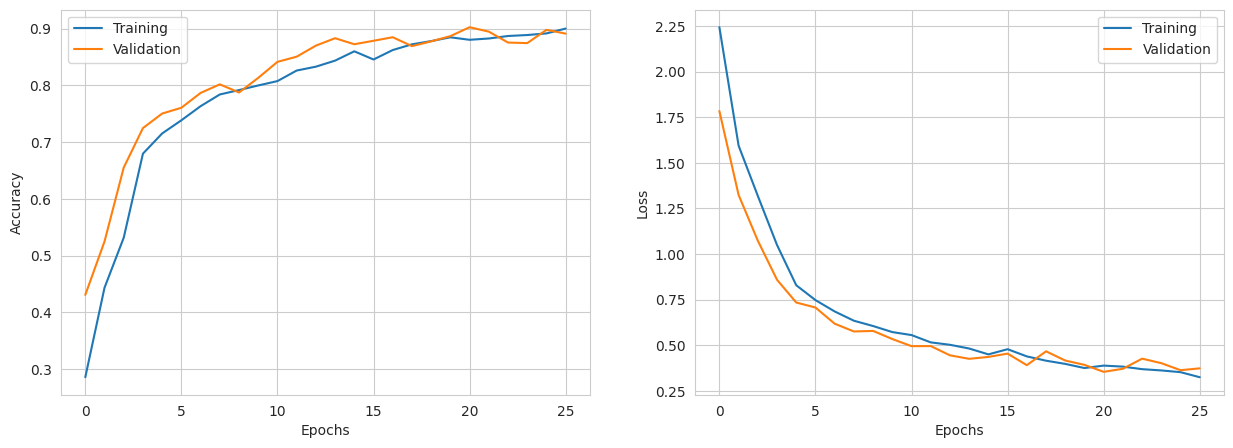

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["Training", "Validation"])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["Training", "Validation"])

plt.show()

## Evaluate the model

In [15]:
def predict_mask(image, model):
    mask_pred = model.predict(image[tf.newaxis, ...], verbose=0)
    mask_pred = tf.argmax(mask_pred, axis=-1)
    mask_pred = mask_pred[..., tf.newaxis]

    return mask_pred[0]

In [16]:
frames = []

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

for image_path, mask_path in zip(image_paths_test, mask_paths_test):
    image, mask = load_image_mask(image_path, mask_path)

    ax1.set_title("Image")
    ax1.axis("off")
    frame1 = ax1.imshow(image, animated=True)

    ax2.set_title("True mask")
    ax2.axis("off")
    frame2 = ax2.imshow(mask, animated=True, cmap="Paired")

    ax3.set_title("Predicted mask")
    ax3.axis("off")
    frame3 = ax3.imshow(predict_mask(image, model), animated=True, cmap="Paired")

    plt.tight_layout()
    frames.append([frame1, frame2, frame3])

anim = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
plt.close(fig)

HTML(anim.to_html5_video())